In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

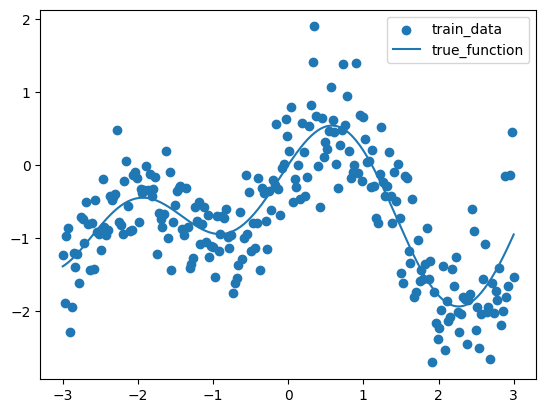

In [44]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [45]:
X.shape

(250, 16)

In [46]:
lamb = 1.0 # picked by hand, we want to find optimal one
alpha = 1.0 / (sigma ** 2) # alpha -> posterior precision (inverted variance)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)
posterior_cov_inv.shape

(16, 16)

In [47]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [48]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

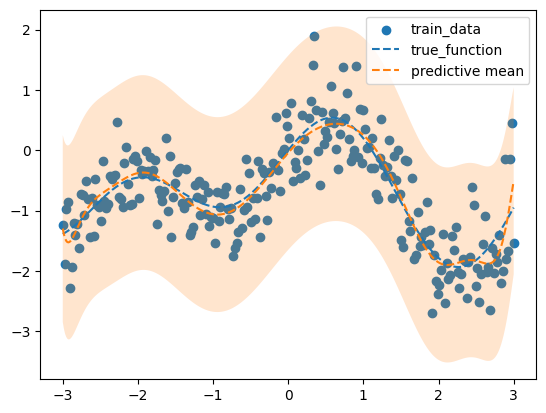

In [49]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [50]:
def log_evidence_num_instable(lamb, X, y, alpha):
    '''
    Тут надо написать расчет log-evidence, через формулу, которая была в лекции
    Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
    Получится лучшая лябмда
    Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой
    '''
    # numerically instable because of dealing with matrix nXn (250x250)
    # need to use Cholesky inverse instead (to deal with mXm (16x16) matrix)
    n = X.shape[0]
    tau_squared = 1.0 / lamb
    C = 1.0 / alpha * np.eye(n) + tau_squared * X @ X.T
    sign, log_det_C = np.linalg.slogdet(C)
    C_inv = np.linalg.inv(C)
    evidence_log = -1/2 * (n * np.log(2*np.pi) + log_det_C + y.T @ C_inv @ y)
    return evidence_log

def log_evidence_cholesky(lamb, X, y, alpha):
    '''
    Тут надо написать расчет log-evidence, через формулу, которая была в лекции
    Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
    Получится лучшая лябмда
    Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой
    '''
    n, m = X.shape
    weights_cov = lamb * np.eye(m) + alpha * (X.T @ X)
    C_cholesky = np.linalg.cholesky(weights_cov)

    C_cholesky_inv = np.linalg.inv(C_cholesky)
    weights_cov_inv = C_cholesky_inv.T @ C_cholesky_inv

    posterior_mean = alpha * (weights_cov_inv @ (X.T @ y))

    mean_pred_error = y - X @ posterior_mean
    data_error = alpha * np.sum(mean_pred_error ** 2)
    weight_decay = lamb * np.sum(posterior_mean ** 2)

    log_det_weights_cov = 2 * np.sum(np.log(np.diag(C_cholesky)))

    evidence_log = 1/2 * (
        m * np.log(lamb) + n * np.log(alpha)
        - log_det_weights_cov - data_error - weight_decay - n * np.log(2*np.pi)
    )
    return evidence_log

In [51]:
# instable variant
lambdas = np.logspace(-6, 3, 160)
log_evidences = [log_evidence_num_instable(lamb, X, y, alpha) for lamb in lambdas]
optimal_lambda = lambdas[np.argmax(log_evidences)]
optimal_lambda

np.float64(0.006200872907625809)

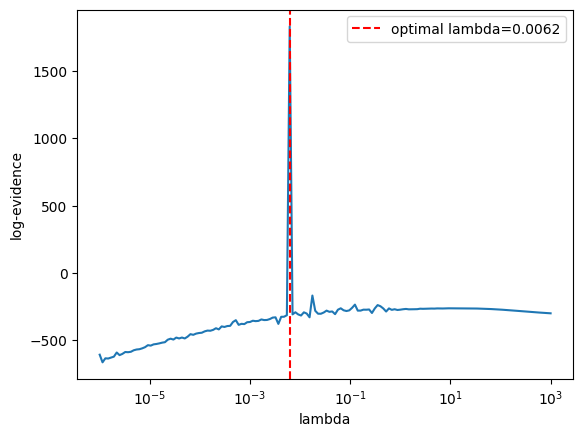

In [52]:
plt.semilogx(lambdas, log_evidences)
plt.axvline(optimal_lambda, color='r', linestyle='--', label=f'optimal lambda={optimal_lambda:.4f}')
plt.xlabel('lambda')
plt.ylabel('log-evidence')
plt.legend()
plt.show()

In [53]:
# stable variant
lambdas = np.logspace(-6, 3, 160)
log_evidences = [log_evidence_cholesky(lamb, X, y, alpha) for lamb in lambdas]
optimal_lambda = lambdas[np.argmax(log_evidences)]
optimal_lambda

np.float64(13.554249376408254)

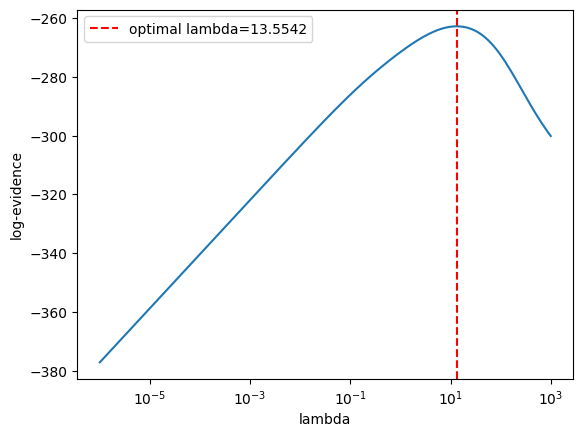

In [54]:
plt.semilogx(lambdas, log_evidences)
plt.axvline(optimal_lambda, color='r', linestyle='--', label=f'optimal lambda={optimal_lambda:.4f}')
plt.xlabel('lambda')
plt.ylabel('log-evidence')
plt.legend()
plt.show() # log-evidence vs lambda

In [55]:
# Оптимальная лямбда (prior precision) получилась примерно 13.554, что значит, что
print(f'Априорная дисперсия весов = {1 / optimal_lambda}')
# Получилось примерно 0.0738, то есть модель ожидает, что веса будут маленькими (стягиваться к нулю)
# => сильная регуляризация (большая лямбда * L2 норма весов)
# => есть риск недообучения

Априорная дисперсия весов = 0.07377760082683313


In [56]:
def posterior_mean_cov(lamb, X, y, alpha):
    m = X.shape[1]
    posterior_cov_inv = lamb * np.eye(m) + alpha * (X.T @ X)
    posterior_cov = np.linalg.inv(posterior_cov_inv)
    mean = alpha * posterior_cov @ (X.T @ y)
    return mean, posterior_cov

In [57]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

# baseline
mean_base, cov_base = posterior_mean_cov(1.0, X, y, alpha)
# with optimal_lambda
mean_opt, cov_opt = posterior_mean_cov(optimal_lambda, X, y, alpha)

mean_pred_base = X_new @ mean_base
var_pred_base = 1.0 / alpha + np.sum((X_new @ cov_base) * X_new, axis=1)
std_pred_base = np.sqrt(var_pred_base)

mean_pred_opt = X_new @ mean_opt
var_pred_opt = 1.0 / alpha + np.sum((X_new @ cov_opt) * X_new, axis=1)
std_pred_opt = np.sqrt(var_pred_opt)

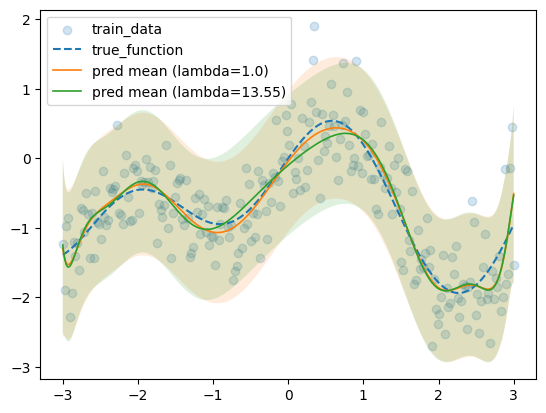

In [61]:
# baseline vs with optimal_lambda
plt.scatter(x, y, label='train_data', alpha=0.2)
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function', linewidth=1.5)
# baseline
plt.plot(x_new, mean_pred_base, label='pred mean (lambda=1.0)', linewidth=1.2)
plt.fill_between(x_new, mean_pred_base - 2*std_pred_base, mean_pred_base + 2*std_pred_base, alpha=0.15)
# with optimal_lambda
plt.plot(x_new, mean_pred_opt, label=f'pred mean (lambda={round(optimal_lambda, 2)})', linewidth=1.2)
plt.fill_between(x_new, mean_pred_opt - 2*std_pred_opt, mean_pred_opt + 2*std_pred_opt, alpha=0.15)

plt.legend()
plt.show()